In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['axes.edgecolor']='black'
matplotlib.rcParams['xtick.color']='black'
matplotlib.rcParams['ytick.color']='black'
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["black", "#e94cdc", "0.7"])
matplotlib.rcParams['axes.linewidth']=1.3
matplotlib.rcParams['text.color']='black'
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.api import VAR
import statsmodels.formula.api as smf

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

### Задача 3

В вашем распоряжении имеются помесячные данные за период
с января 2001 по декабрь 2010 года о расходах на рекламу и объемах
продаж регионального подразделения транснациональной корпорации
(файл Advert): $x_{t}$ — расходы фирмы на рекламу, $y_{t}$ — объем продаж
фирмы.

(а) Осуществите для рассматриваемых переменных тест Грейнжера на
причинно-следственную связь (используйте первый, второй и третий
лаги для каждой из переменных). Интерпретируйте результаты теста.

(б) Оцените регрессию $y_{t}$ на константу, $x_{t}$, $x_{t-1}$ и $x_{t-2}$. Дайте содержательную
интерпретацию полученных результатов. Осуществите тест
Дарбина — Уотсона и интерпретируйте его результаты. Можно ли использовать
в представленной модели обычные стандартные ошибки или необходимо использовать состоятельные в условиях автокорреляции
стандартные ошибки?

(в) Если в исходной модели были незначимые переменные, то оцените
модель заново, исключив их. Осуществите тест Дарбина — Уотсона и
интерпретируйте его результаты.

(г) Оцените регрессию $y_{t}$ на константу, $x_{t}$, $x_{t-1}$ и $y_{t-1}$. Дайте содержательную интерпретацию полученных результатов. Почему в этой модели
нельзя использовать тест Дарбина — Уотсона? Каким образом
можно проверить, есть ли автокорреляция в новой модели?

(д) Сравните полученные в предыдущих пунктах модели, и выберите
наиболее удачную из них.

In [3]:
dat = pd.read_excel('/Users/tony/Desktop/advert.xlsx')

In [4]:
dat.head()

,x,y
0,4,27.0
1,3,25.7
2,0,24.3
3,5,23.2
4,3,27.6


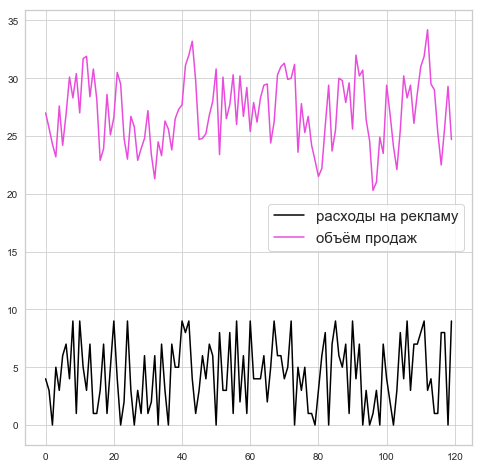

In [5]:
plt.plot(dat.x, label='расходы на рекламу')
plt.plot(dat.y, label='объём продаж')
plt.legend(fontsize=15);

Создадим функцию для оценки ADL модели

In [6]:
import pandas as pd
import statsmodels.formula.api as smf
import itertools

def lags_df(dataframe, lags_dict, target_variable):
    """
    param dataframe: df содержащий необходимые переменные
    param target_variable: (str) название зависимой переменной
    param lags_dict: (dict) словарь: ключи - названия (str) колонок в dataframe, которые будут 
    использоваться для регрессии, значения (list) - списки лагов для каждой из переменных
    """
    dat_dict = {}
    max_lag = 0
    for varname in lags_dict:
        m_l = np.max(lags_dict[varname])
        if m_l > max_lag:
            max_lag = m_l
    target_variable_array = dataframe[target_variable].values[max_lag:]
    dat_dict.update({'target': target_variable_array})
    target_len = len(target_variable_array)
    colnames_list = ['target']
    for varname in lags_dict:
        variable_len = len(dataframe[varname])
        for lag in lags_dict[varname]:
            dat_dict.update({varname + '_{}'.format(lag): dataframe[varname].values[max_lag-lag : variable_len-lag]})
            colnames_list.append('{}_{}'.format(varname, lag))
    return pd.DataFrame(dat_dict, columns=colnames_list)
    

def adl_regression(dataframe, target_variable, lags_dict=None,
                   cov_type='nonrobust', model_type='gls'):
    """
    param dataframe: df содержащий необходимые переменные
    param target_variable: (str) название зависимой переменной
    param lags_dict: (dict) словарь: ключи - названия (str) колонок в dataframe, которые будут 
    использоваться для регрессии, значения (list) - списки лагов для каждой из переменных
    param cov_type: ['nonrobust', 'HC0', 'HC1', 'HC2', 'HC3']
    param model_type: ['ols', 'gls']
    """
    if lags_dict is not None:
        dat_dict = {}
        max_lag = 0
        for varname in lags_dict:
            m_l = np.max(lags_dict[varname])
            if m_l > max_lag:
                max_lag = m_l
        target_variable_array = dataframe[target_variable].values[max_lag:]
        dat_dict.update({'target': target_variable_array})
        target_len = len(target_variable_array)
        colnames_list = ['target']
        for varname in lags_dict:
            variable_len = len(dataframe[varname])
            for lag in lags_dict[varname]:
                dat_dict.update({varname + '_{}'.format(lag): dataframe[varname].values[max_lag-lag : variable_len-lag]})
                colnames_list.append('{}_{}'.format(varname, lag))
        data_for_regression = pd.DataFrame(dat_dict, columns=colnames_list)
    else:
        data_for_regression = dataframe
    formula = ' '.join(['{}'.format(varname) + ' + ' for varname in data_for_regression.columns[:-1]])[:-3]
    if model_type == 'ols':
        model = smf.ols('target ~ ' + formula, data=data_for_regression).fit(cov_type=cov_type)
    else:
        model = smf.gls('target ~ ' + formula, data=data_for_regression).fit()
    return model


(a)

In [7]:
df1 = lags_df(dat, target_variable='y', lags_dict={'x': [1, 2, 3], 'y': [1, 2, 3]})
x_cause_y_model = smf.ols('target ~ x_1 + x_2 + x_3 + y_1 + y_2 + y_3', data=df1).fit()
R = np.array([[0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0]])
print(x_cause_y_model.f_test(R))

<F test: F=array([[ 166.9698328]]), p=8.534721573666172e-41, df_denom=110, df_num=3>


In [8]:
df1 = lags_df(dat, target_variable='x', lags_dict={'x': [1, 2, 3], 'y': [1, 2, 3]})
y_cause_x_model = smf.ols('target ~ x_1 + x_2 + x_3 + y_1 + y_2 + y_3', data=df1).fit()
R = np.array([[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1]])
print(y_cause_x_model.f_test(R))

<F test: F=array([[ 0.35306671]]), p=0.787003231270685, df_denom=110, df_num=3>


Принимаем гипотезу о том, что x - "причина по Грейнджеру" для y

Тот же вывод можно сделать из VAR модели

In [9]:
model1 = VAR(dat).fit(3)

In [10]:
granger_test = model1.test_causality(caused='y', causing='x', kind='f')
print(granger_test.h0)
print(granger_test.conclusion)
granger_test = model1.test_causality(caused='x', causing='y', kind='f')
print(granger_test.h0)
print(granger_test.conclusion)

H_0: x does not Granger-cause y
reject
H_0: y does not Granger-cause x
fail to reject


(б)

In [11]:
df2 = lags_df(dat, target_variable='y', lags_dict={'x': [1, 2, 3]})
adl_model = smf.ols('target ~ x_1 + x_2 + x_3', data=df2).fit()
print(adl_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     164.6
Date:                Sat, 18 May 2019   Prob (F-statistic):           4.37e-41
Time:                        13:02:25   Log-Likelihood:                -196.41
No. Observations:                 117   AIC:                             400.8
Df Residuals:                     113   BIC:                             411.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.7055      0.347     59.725      0.0

Критические значения Дарбина-Уотсона для данного случая: $d_{L}$ = 1.61, $d_{U}$ = 1.74 http://berument.bilkent.edu.tr/DW.pdf

DW-statisic < $d_{L} \Rightarrow$ принимает гипотезу о том, что имеется положительная автокорреляция в остатках

In [12]:
hat_pho = 0.4255
consistent_df = lags_df(dat, target_variable='y', lags_dict={"x": [1, 2, 3]})
consistent_df.head()

,target,x_1,x_2,x_3
0,23.2,0,3,4
1,27.6,5,0,3
2,24.2,3,5,0
3,26.9,6,3,5
4,30.1,7,6,3


Проведём вручную взвешенный мнк

In [13]:
intermediate_df = lags_df(consistent_df, target_variable='target', lags_dict={'x_1': [0, 1], 'x_2': [0, 1], 'x_3': [0, 1], 'target': [1]})
new_df = pd.DataFrame(np.zeros((intermediate_df.shape[0], consistent_df.shape[1])), columns=consistent_df.columns)
new_df['target'] = intermediate_df['target'] - hat_pho*intermediate_df['target_1']
for varname in consistent_df.columns:
    if varname != 'target':
        new_df[varname] = intermediate_df[varname + '_0'] - hat_pho*intermediate_df[varname + '_1']


In [14]:
new_df.head()

,target,x_1,x_2,x_3
0,17.72840,5.0000,-1.2765,1.2980
1,12.45620,0.8725,5.0000,-1.2765
2,16.60290,4.7235,0.8725,5.0000
3,18.65405,4.4470,4.7235,0.8725
4,15.49245,1.0215,4.4470,4.7235


In [15]:
model_gls = smf.ols('target ~ x_1 + x_2 + x_3', data=new_df).fit()
print(model_gls.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     155.9
Date:                Sat, 18 May 2019   Prob (F-statistic):           7.91e-40
Time:                        13:02:35   Log-Likelihood:                -182.85
No. Observations:                 116   AIC:                             373.7
Df Residuals:                     112   BIC:                             384.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.0314      0.254     47.460      0.0

(г)

In [16]:
df3 = lags_df(dat, target_variable='y', lags_dict={'x': [1, 2], 'y': [1]})
adf_model2 = smf.ols('target ~ x_1 + x_2 + y_1', data=df3).fit()
print(adf_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     229.4
Date:                Sat, 18 May 2019   Prob (F-statistic):           3.98e-48
Time:                        13:02:37   Log-Likelihood:                -182.07
No. Observations:                 118   AIC:                             372.1
Df Residuals:                     114   BIC:                             383.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3522      1.347      7.687      0.0

### Задача 4

Файл с данными: USMacro_Monthly

Повышение цен на нефть не раз становилось причиной рецессий в развитых
странах. Для эмпирического исследования последствий шоков цен на
нефть воспользуемся следующими данными:

$Oil_{t}$ — переменная, равная максимуму из двух чисел: нуля и разности
между ценой нефти в момент времени t и ее максимальным значением в
предшествующий моменту t год. (Переменная измеряется в процентных
пунктах.) Таким образом, переменная равна нулю, если шок цен на нефть
в текущем периоде отсутствует (текущая цена нефти не превышает максимум
за прошедший год).

$IP_{t}$ — индекс промышленного производства в США в месяце t.
Будем предполагать, что цены на нефть, складываются на мировом
рынке и являются экзогенными для нашей модели.

(а) Вычислите темп прироста промышленного производства в процентах
к предыдущему месяцу по формуле $ip\_growth_{t} = \log \frac{IP_{t}}{IP_{t-1}} \cdot 100 \%$. Чему равны среднее значение и стандартное отклонение этой переменной за
период 1952:1–2009:12?

(б) Постройте график временного ряда $Oil_{t}$. Почему так много значений
этой переменно равны нулю? Почему эта переменная никогда не принимает
отрицательных значений?

(в) Оцените модель распределенных лагов для переменной $ip\_growth_{t}$ в
зависимости от константы, текущего значения $Oil_{t}$ и 18 лагов (полуторагодовой
период). Не забудьте воспользоваться робастными стандартными
ошибками (HAC standard errors). 

In [17]:
dat = pd.read_excel('/Users/tony/Desktop/UsMacro_Monthly.xlsx')

In [18]:
dat.head()

,Year,Month,IP,Oil
0,1947,1,13.5852,NaN
1,1947,2,13.6655,NaN
2,1947,3,13.7457,NaN
3,1947,4,13.6387,NaN
4,1947,5,13.6922,NaN


In [19]:
dat['ip_growth'] = [np.log([i/j for i,j in zip(dat.IP[1:], dat.IP)]).mean()*100] + np.log([(i/j)*100 for i,j in zip(dat.IP[1:], dat.IP)]).tolist()
dat = dat.loc[1:]

In [20]:
index1 = dat.loc[(dat.Year == 1952)&(dat.Month == 1)].index[0]
index2 = dat.loc[(dat.Year == 2009)&(dat.Month == 12)].index[0]
dat.ip_growth[index1:index2].describe()

count    695.000000
mean       4.607543
std        0.009483
min        4.564812
25%        4.603184
50%        4.607913
75%        4.612164
max        4.667495
Name: ip_growth, dtype: float64

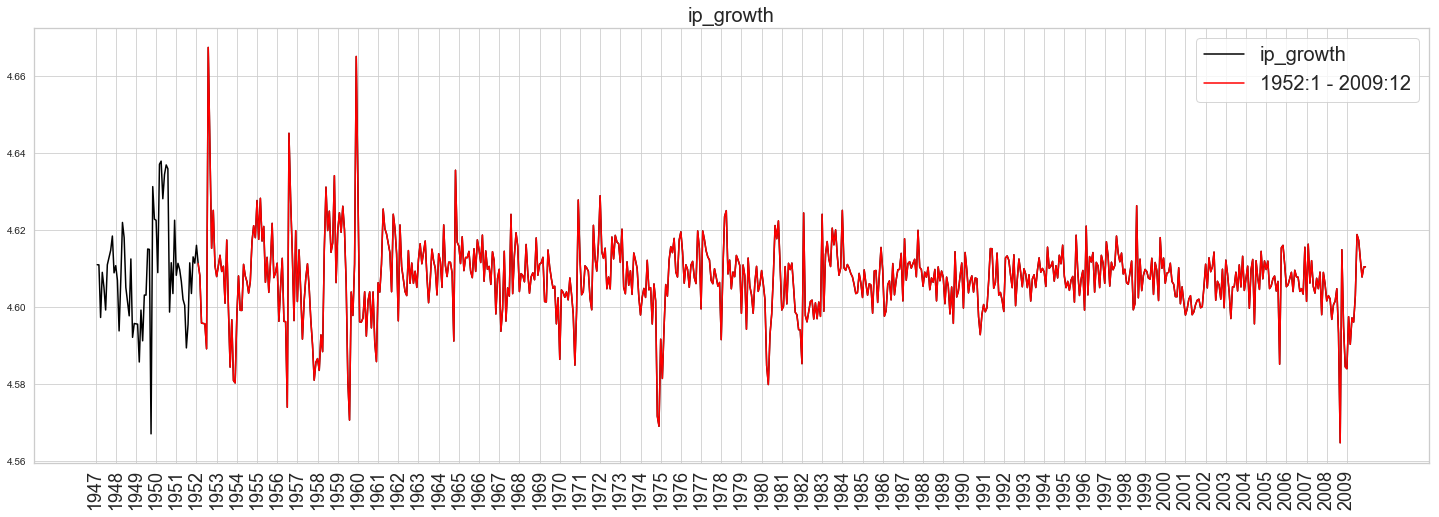

In [21]:
plt.figure(figsize=(25, 8))
plt.plot(dat.ip_growth)
plt.plot(dat.ip_growth[index1:index2], color='red', label='1952:1 - 2009:12')
plt.xticks(np.arange(0, dat.ip_growth.shape[0], 12), np.arange(1947, 2010), rotation=90, 
           fontsize=18);
plt.title('ip_growth', fontsize=20);
plt.legend(fontsize=20);

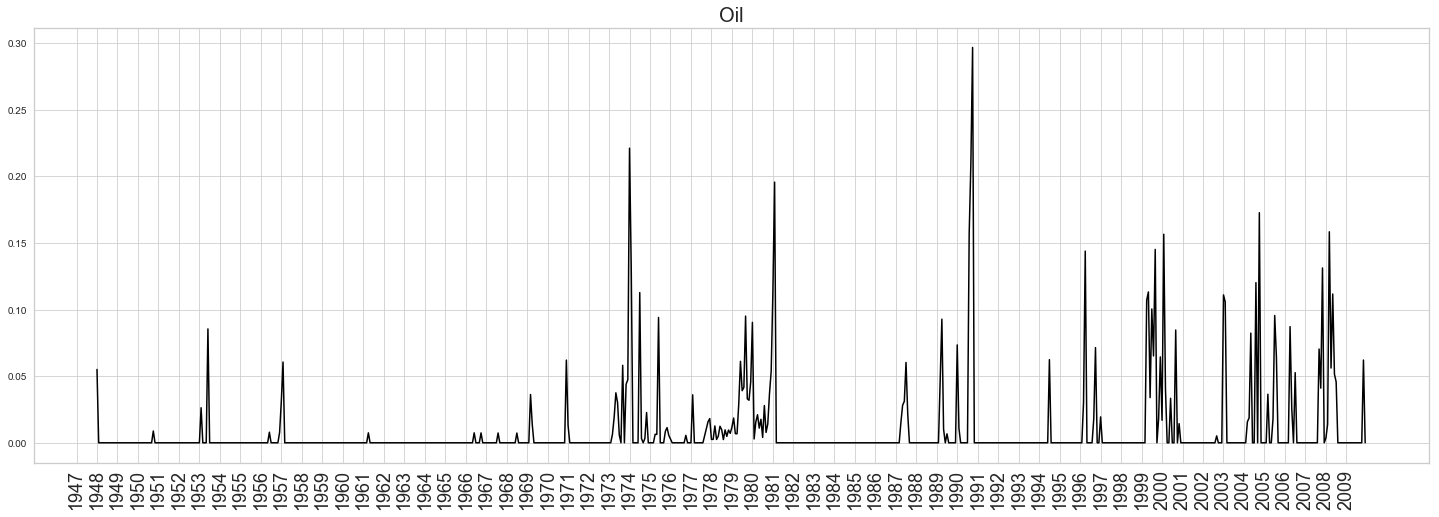

In [22]:
plt.figure(figsize=(25, 8))
plt.plot(dat.Oil)
plt.xticks(np.arange(0, dat.Oil.shape[0], 12), np.arange(1947, 2010), rotation=90, 
           fontsize=18);
plt.title('Oil', fontsize=20);

In [23]:
df = lags_df(dat, target_variable='ip_growth', lags_dict={"Oil": list(range(1, 18+1))})
formula = 'target ~ '
for i in range(1, 18+1):
    formula += 'Oil_{}'.format(i) + ' +'
model_ip_growth = smf.ols(formula[:-2], data=df).fit(cov_type='HC0')
print(model_ip_growth.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.162
Date:                Sat, 18 May 2019   Prob (F-statistic):           1.12e-05
Time:                        13:02:52   Log-Likelihood:                 2351.8
No. Observations:                 726   AIC:                            -4666.
Df Residuals:                     707   BIC:                            -4578.
Df Model:                          18                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6095      0.000   9922.776      0.0

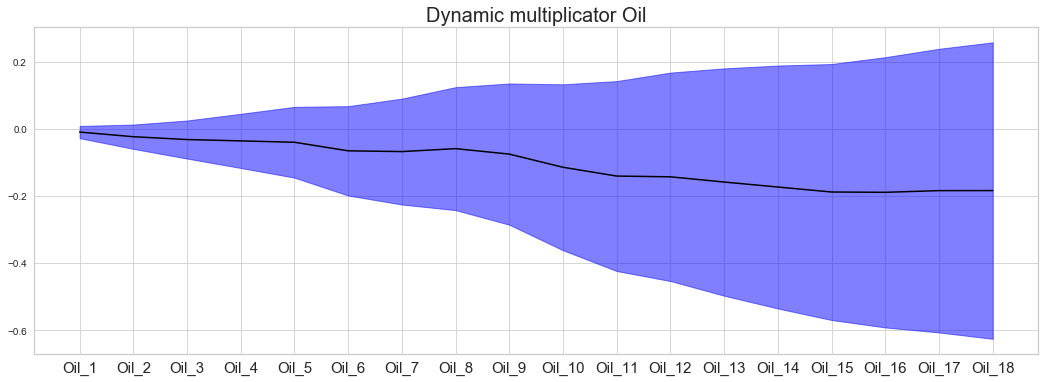

In [24]:
plt.figure(figsize=(18, 6))
lower = model_ip_growth.conf_int()[0].values[1:]
upper = model_ip_growth.conf_int()[1].values[1:] 
plt.plot(model_ip_growth.params.keys()[1:], model_ip_growth.params[1:].cumsum())
plt.fill_between(model_ip_growth.params.keys()[1:], lower.cumsum(), 
                 upper.cumsum(), alpha=0.5, color='blue')
plt.xticks(fontsize=15);
plt.title('Dynamic multiplicator Oil', fontsize=20);